# AdaBoost
Haytham Mohamed

INFS 890 - Spring 2020

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor #For Regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection, tree
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [74]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True
SCALE_FEATURES = True

FEATURES_SELECTION = True

test_split = 0.2

In [75]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [76]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)

print('data shape {}'.format(data.shape))

data.head(5)

data shape (6766, 29)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,...,user-db_net_use,shipping_net_use,payment_net_use,carts_net_use,carts-db_net_use,nodes_cpu_use,nodes_disk_io,nodes_net_use,orders_req,orders_ltcy
0,0.0300,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0300,0.0700,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,2.5000,1.6700,2.7617,0.1500,0.2400
1,0.0600,0.0200,0.0200,0.0200,0.0200,0.0100,0.0100,0.1800,0.1800,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,1.8900,1.0100,2.7617,0.1500,0.2400
2,0.0700,0.0300,0.0200,0.0300,0.0200,0.0100,0.0100,0.4400,0.2000,1.0000,...,16.0739,13.5708,16.9964,27.3438,16.6522,1.3500,0.0500,2.5880,0.1500,0.2400
3,0.0700,0.0300,0.0200,0.0200,0.0200,0.0100,0.0100,0.2300,0.1700,1.0000,...,19.9869,14.4342,9.5804,9.4313,17.1768,1.2600,0.0400,2.1487,0.1300,0.2400
4,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.2400,0.1400,1.0000,...,10.4490,3.7392,2.7970,9.1791,6.2516,1.2800,0.2600,1.8080,0.3600,0.2400


In [77]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 28 features


In [78]:
# print out the features
for feature in inputs.columns.values:
    print(feature)

front-end_cpu_use
orders_cpu_use
orders-db_cpu_use
user_cpu_use
user-db_cpu_use
shipping_cpu_use
payment_cpu_use
carts_cpu_use
carts-db_cpu_use
front-end_pods
orders_pods
user_pods
shipping_pods
payment_pods
carts_pods
front-end_net_use
orders_net_use
orders-db_net_use
user_net_use
user-db_net_use
shipping_net_use
payment_net_use
carts_net_use
carts-db_net_use
nodes_cpu_use
nodes_disk_io
nodes_net_use
orders_req


# Features Selection

In [79]:
def features_selection(x, y, to_scale=FEATURES_SELECTION):
    if to_scale:  
        #clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)    
        clf = LassoCV(tol=0.1)
        sfm = SelectFromModel(clf, threshold='0.05*mean')

        selectedFeatures = sfm.fit(x, y).transform(x)
        print('{} features selected'.format(selectedFeatures[1].shape[0]))
        
        feature_list = x.columns[sfm.get_support()]
        features = ''
        features = ', '.join(feature_list)
    
        print("columns selected are {}".format(features))

        x = x[feature_list]        
    return x


In [80]:
inputs = features_selection(inputs, targets, )

12 features selected
columns selected are carts_cpu_use, carts-db_cpu_use, front-end_pods, orders_net_use, orders-db_net_use, user_net_use, shipping_net_use, payment_net_use, carts_net_use, nodes_cpu_use, nodes_net_use, orders_req


In [81]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))
    
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)  

if SCALE_FEATURES:
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)

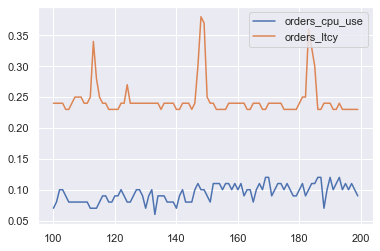

In [82]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()


# Model

In [83]:

dt = tree.DecisionTreeRegressor() 
reg = AdaBoostRegressor(n_estimators=200, base_estimator=dt,learning_rate=0.5, random_state=100, loss='exponential')


In [84]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

reg.fit(x_train, y_train)

sklearn version 0.22.2.post1


/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

# Training R2

In [85]:
y_train_pred = reg.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_pred)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(reg.score(x_train,y_train)))

R2 (training) = 0.927931096993173
Score (training) = 0.927931096993173


In [86]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_pred)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.37 (0.33) 0.00 1.00 MSE


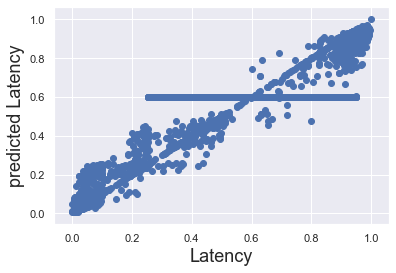

In [87]:
plt.scatter(y_train, y_train_pred)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

# Testing

In [88]:
y_test_pred = reg.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

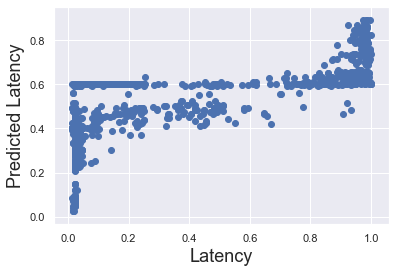

In [89]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

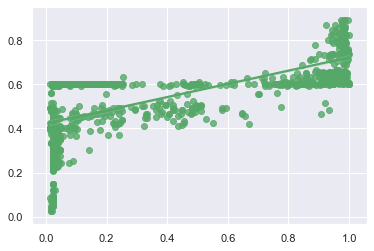

In [90]:
ax = sns.regplot(x=y_test, y=y_test_pred, color='g')

In [91]:
perf = pd.DataFrame(y_test_pred, columns=['prediction'])
perf['target'] = y_test
perf.head()

,prediction,target
0,0.6013,0.2517
1,0.6013,0.2510
2,0.6013,0.2504
3,0.6013,0.2497
4,0.6013,0.2491


In [92]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,0.6013,0.2517,0.3496,138.9009
1,0.6013,0.2510,0.3503,139.5202
2,0.6013,0.2504,0.3509,140.1428
3,0.6013,0.2497,0.3516,140.7686
4,0.6013,0.2491,0.3522,141.3976
...,...,...,...,...
1349,0.8294,0.9877,-0.1583,16.0250
1350,0.7441,0.9877,-0.2436,24.6618
1351,0.6516,0.9856,-0.3340,33.8895
1352,0.6536,0.9887,-0.3350,33.8877


In [93]:
perf.describe()

,prediction,target,residual,difference%
count,"1,354.0000","1,354.0000","1,354.0000","1,354.0000"
mean,0.5108,0.2942,0.2167,695.2816
std,0.1755,0.3593,0.2874,815.4023
min,0.0236,0.0134,-0.4491,0.1601
25%,0.3998,0.0236,0.0239,34.7049
50%,0.5975,0.1062,0.3022,319.5090
75%,0.6013,0.4838,0.4458,979.8092
max,0.8931,1.0000,0.5857,"4,070.3310"


In [94]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.4f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
888,0.6105,0.6115,-0.0010,0.1601
975,0.5005,0.4995,0.0010,0.2058
1002,0.4943,0.4933,0.0010,0.2083
1047,0.5971,0.5930,0.0041,0.6961
935,0.5067,0.5108,-0.0041,0.8048
...,...,...,...,...
1136,0.5601,0.0164,0.5437,3306.2500
1298,0.4933,0.0144,0.4789,3328.5714
1181,0.5601,0.0154,0.5447,3533.3333
1157,0.4933,0.0134,0.4800,3592.3077


# *** Prediction Accuracy

In [95]:
r2_test = metrics.r2_score(y_test, y_test_pred)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = -0.003844286520678919


In [96]:
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

0.3598368348047907
